In [1]:
# Reload all modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import json
from urllib.parse import urljoin
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import osmnx as ox  

import cafeconmiel.data.metadata as metadata
import cafeconmiel.data.token_counts as token_counts
import cafeconmiel.utils.paths as paths_utils

from dotenv import load_dotenv
load_dotenv()

True

In [3]:
paths = paths_utils.ProjectPaths()
interim_data = paths.interim_data
raw_data = paths.raw_data

In [4]:
with open(paths.ext_data / 'corpora.json') as f:
    corpus_metadata = json.load(f)

# Load pre-processed data

In [412]:
corpus_name = 'postscriptum'
# corpus_name = 'corpuscodea'
corpus_dir = interim_data / corpus_name

In [413]:
records = []
for path in corpus_dir.glob('*.json'):
    with open(path) as f:
        records.append(json.load(f))
auto_df = pd.DataFrame.from_records(records)
auto_df = auto_df.set_index('meta_id')
auto_df = metadata.normalize(auto_df)
auto_df.head()

,file_id,abstract,keywords,author,place,date,doc_type,text,year,locality,region
meta_id,,,,,,,,,,,
PSCR7516,PSCR7516,"El autor informa a su esposa, Agustina Campana...",,Francisco Grande,"España, Toledo",1775-12-03,"family letter, for information",\n\n Agustina desde la noche de el dia siete\n...,1775.0,España,Toledo
PSCR5547,PSCR5547,El autor pide a Gaspar de Cemedo que le remita...,"\n\t\t\t\t\t, Correspondencia, \n\t\t\t\t\t, P...",Mateo de Molina,"España, Toledo",1752,"friendship letter, for request",\n\n\n Gaspar anoche me\n escrivio el Visr pre...,1752.0,España,Toledo
PSCR6628,PSCR6628,La autora escribe a su hermana María Polonia p...,"\n\t\t\t\t\t, Familia, \n\t\t\t\t\t, Dinero, \...",María Josefa de Rivas Berasategui,"España, Álava, Vitoria",1747-07-17,"family letter, for news",\n\n Herma y qda mia sientto el q\n dn Pedro M...,1747.0,España,Álava
PSCR5423,PSCR5423,El autor narra a Isabel de Briñas su mala situ...,"\n\t\t\t\t\t, Enfermedad, \n\t\t\t\t",Domingo Daza,"España, Madrid",1639,"personal letter, for request",\n ihs\n\n Hija mia casi me alegro de q quando...,1639.0,España,Madrid
PSCR8546,PSCR8546,El autor avisa a Manuel Crespo sobre las dific...,"\n\t\t\t\t\t, Dinero, \n\t\t\t\t\t, Correspond...",Juan de Santa Olalla,"España, Toledo, Madridejos",1759-11-16,"friendship letter, for warning",\n Madridexos y Nre 16 de 1759\n\n Amigo Dn Ma...,1759.0,España,Toledo


Load all documents

In [170]:
corpus_name = 'all'
list_df = []
for c in corpus_metadata.keys(): # [k for k in corpus_metadata.keys() if k != 'postscriptum']:
    corpus_dir = interim_data / c
    records = []
    for path in corpus_dir.glob('*.json'):
        with open(path) as f:
            records.append(json.load(f))
    df = pd.DataFrame.from_records(records)
    df = df.loc[df['text'].notnull()].set_index('meta_id')
    df = metadata.normalize(df)
    df['corpus'] = c
    list_df.append(df)
auto_df = pd.concat(list_df, axis=0, join='inner')

In [171]:
# remove duplicates between codea and charta
auto_df = auto_df.groupby('meta_id').first().drop_duplicates()

In [172]:
auto_df['is_private'] = (
    auto_df['doc_type'].isin(['cartas privadas', 'cartas particulares'])
    | auto_df['doc_type'].str.extract('(.*) letter,')[0].isin(
        ['personal', 'family', 'friendship', 'love']
    )
)
auto_df['is_BA'] = (auto_df['region'].str.endswith('Baleares').fillna(False)) | (auto_df['corpus'] == 'corpusmallorca')

In [173]:
auto_df.head()

,year,locality,region,country,abstract,doc_type,text,corpus,is_private,is_BA
meta_id,,,,,,,,,,
AA001_01,1702.0,Palma,Islas Baleares,España,El procurador fiscal de la Real Audiencia de M...,informes y relaciones,\nExcelentisimo Señor\n En cumplimiento del o...,corpusmallorca,False,True
AA001_02,1702.0,Palma,Islas Baleares,España,Traslado de un documento de 1676 de la reina r...,informes y relaciones,A los Illustre Marques de la Casta Pariente m...,corpusmallorca,False,True
AA001_03,1704.0,Palma,Islas Baleares,España,El oidor de la Real Audiencia de Mallorca Migu...,informes y relaciones,"\nJHS\nCon las mesmas protestaciones, que en ...",corpusmallorca,False,True
AA001_04,1704.0,Palma,Islas Baleares,España,El produrador fiscal de la Real Audiencia de M...,informes y relaciones,\nIhs. Acceptando el Procurador Fiscal de la ...,corpusmallorca,False,True
AA002_01,1720.0,Palma,Islas Baleares,España,Auto del notario Jaime Martí en que da parte d...,actas y declaraciones,Procedimientos echos por la Júrisdiçion Real ...,corpusmallorca,False,True


# Compare manually and automatically cleaned texts

In [ ]:
letters_path = paths.ext_data / 'Cartas-txt'
legal_docs_path = paths.ext_data / 'documentos arreglados CorpMA'

In [ ]:
manual_docs = {}
for fpath in letters_path.iterdir():
    match = re.match(r'.*_Lit \((.+)\)', fpath.name)
    if match is not None:
        doc_id = match.groups()[0]     
    with open(fpath, 'r') as f:
        manual_docs[doc_id] = f.read()

In [ ]:
manual_docs = {}
for fpath in legal_docs_path.iterdir():
    match = re.match(r'(.+)p.txt', fpath.name)
    if match is not None:
        doc_id = match.groups()[0]     
        with open(fpath, 'r', encoding='Windows-1252') as f:
            manual_docs[doc_id] = f.read()

In [ ]:
for doc_id, text_by_hand in manual_docs.items():
    path = interim_data / f'{doc_id}.json'
    if path.exists():
        with open(interim_data / f'{doc_id}.json', 'r') as f:
            text_auto = json.load(f)['text']
        print(f'** {doc_id} **')
        print(text_by_hand)
        print(text_auto)
        break

this is a mess, nothing corresponds

In [ ]:
real_id = 'AMPO01_01'
manual_id = 'AMPO01_03'
text_by_hand = manual_docs[manual_id]
with open(interim_data / f'{real_id}.json', 'r') as f:
    text_auto = json.load(f)['text']
print(f'** {doc_id} **')
print(text_by_hand)
print(text_auto)

did it with AMPO01_01, which corresponds partly to AMPO01_03 (last paragraph), and removing \n and spaces, I get exact match

# Get places locations

In [ ]:
from collections import defaultdict
places = defaultdict(lambda: 0)
places_dict = {}
for doc_id in doc_ids:
    with open(interim_data / f'{doc_id}.json', 'r') as f:
        p = json.load(f)['place']
        places[p] += 1
        places_dict[doc_id] = p

In [ ]:
tags = {'place': 'city'}
gdf = ox.geometries_from_place('Madrid, Madrid', tags)
gdf

/home/thomaslouf/.conda/envs/cafeconmiel/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


,,admin_level,capital,ele,is_capital,name,name:ab,name:am,name:an,name:ar,name:arc,...,source,source:date,source:ele,source:file,source:name,source:name:oc,source:population,wikidata,wikipedia,geometry
element_type,osmid,,,,,,,,,,,,,,,,,,,,,
node,21068295,2,yes,655,country,Madrid,Мaдрид,ማድሪድ,Madrit,مدريد,ܡܕܪܝܕ,...,Instituto Geográfico Nacional,2011-06,MDT5,http://centrodedescargas.cnig.es/CentroDescarg...,Nomenclátor Geográfico de Municipios y Entidad...,Lo Congrès,"BOE REAL DECRETO 1683/2007, de 14 de diciembre",Q2807,es:Madrid,POINT (-3.70358 40.41670)


# Quick viz

In [174]:
# doc_df = auto_df[['doc_type', 'year', 'text'] + place_cols].copy()
doc_df = auto_df.copy()

In [37]:
figs_path = paths.proj / 'reports' / 'figures' / corpus_name
figs_path.mkdir(parents=True, exist_ok=True)

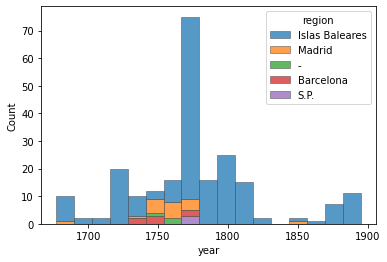

In [ ]:
top_regions = doc_df.groupby('region').size().sort_values().tail(5).index
ax = sns.histplot(
    doc_df.loc[doc_df['region'].isin(top_regions)],
    x="year", hue="region",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
ax.get_figure().savefig(figs_path / 'year_hist_by_region.pdf')

legal docs will most probably be useless, first for their content bu also region distribution: almost exclusively in baleares

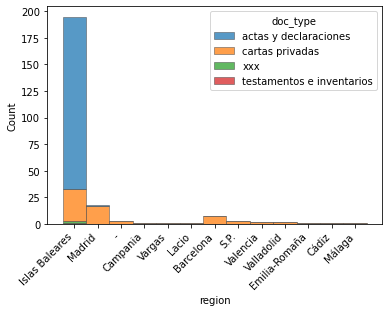

In [ ]:
ax = sns.histplot(
    doc_df,
    x="region", hue="doc_type",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
for item in ax.get_xticklabels():
    item.set_rotation(45)
    item.set_horizontalalignment('right')

ax.get_figure().savefig(figs_path / 'region_hist_by_doc_type.pdf', bbox_inches='tight')

however letters have very small year range

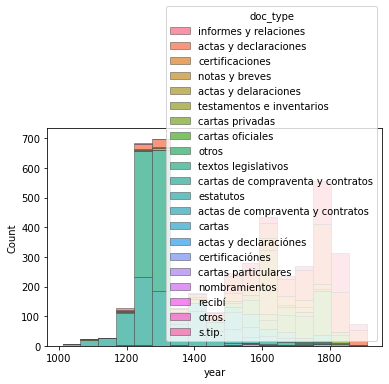

In [517]:
ax = sns.histplot(
    doc_df,
    x="year", hue="doc_type",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    # legend=False
)
# ax.get_figure().savefig(figs_path / 'year_hist_by_doc_type.pdf')

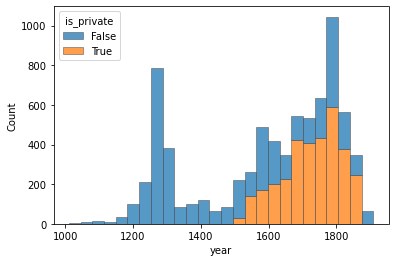

In [38]:
ax = sns.histplot(
    doc_df,
    x="year", hue="is_private",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
# ax.get_figure().savefig(figs_path / 'year_hist_private_or_not.pdf')

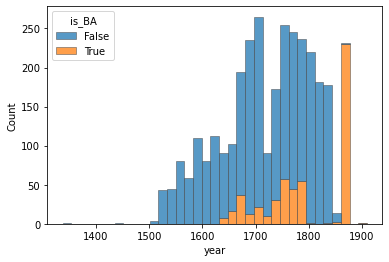

In [52]:
ax = sns.histplot(
    doc_df.loc[doc_df['is_private']],
    x="year", hue="is_BA",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)

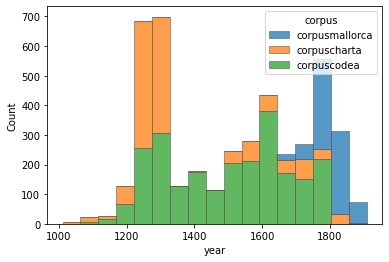

In [44]:
ax = sns.histplot(
    doc_df,
    x="year", hue="corpus",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
# ax.get_figure().savefig(figs_path / 'year_hist_corpus.pdf')

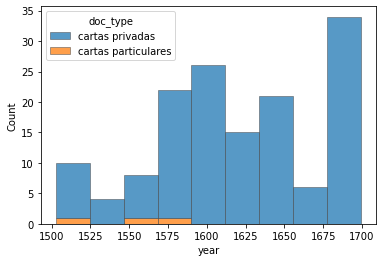

In [55]:
ax = sns.histplot(
    doc_df.loc[(doc_df['corpus'] == 'corpuscodea')
               & (doc_df['year'] > 1500)
               & (doc_df['year'] < 1700)
               & ((doc_df['doc_type'] == 'cartas privadas')
               | (doc_df['doc_type'] == 'cartas particulares'))],
    x="year", hue="doc_type",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)

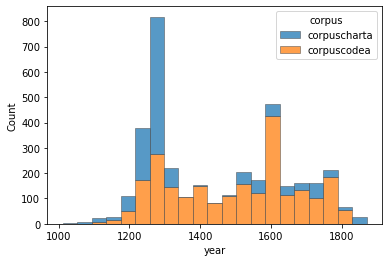

In [193]:
ax = sns.histplot(
    doc_df.loc[doc_df['corpus'] != 'corpusmallorca'],
    x="year", hue="corpus",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
ax.get_figure().savefig(figs_path / 'docs_charta-codea_time.pdf')

# Classification BAL / notBAL 

## Word counts

In [175]:
doc_df = auto_df.copy()
# doc_type_mask = doc_df['doc_type'] == 'cartas privadas'
# doc_type_mask = ~doc_df['is_private'] # & (doc_df['corpus'] != 'postscriptum)
doc_type_mask = doc_df['corpus'] == 'corpuscharta'
years_mask = (doc_df['year'] >= 1700) & (doc_df['year'] < 1800)
doc_mask = doc_type_mask & years_mask

words_count_by_doc = token_counts.count_by_doc(doc_df.loc[doc_mask])
global_counts = token_counts.doc_counts_to_global(words_count_by_doc)
# global_counts = token_counts.word_mask(global_counts, min_df=5, max_df=0.5, upper_th=0.4)
global_counts = token_counts.word_mask(global_counts, min_df=0, max_df=1.0, upper_th=1.1)
print(global_counts['word_mask'].sum())
normed_words_count_by_doc = token_counts.filter_doc_counts(
    words_count_by_doc, global_counts['word_mask']
)
normed_words_count_by_doc.head()

10261


count  word_mask
meta_id   word_lower                  
CDHM-0011 a              13       True
          aca             1       True
          adsunpto        1       True
          agires          1       True
          agradesida      1       True

In [99]:
doc_df.loc[doc_mask].groupby('corpus').size()

corpus
corpuscharta       94
corpuscodea       149
corpusmallorca    308
postscriptum       47
dtype: int64

In [106]:
normed_words_count_by_doc.groupby('meta_id')['count'].sum().rename('nr_tokens').to_frame().join(doc_df[['corpus']]).groupby('corpus')['nr_tokens'].sum()

corpus
corpuscharta       75982
corpuscodea        30341
corpusmallorca    241973
postscriptum       15154
Name: nr_tokens, dtype: int64

In [ ]:
doc_df['nr_chars'] = doc_df['text'].str.len()
doc_df.loc[doc_mask].groupby('corpus')['nr_chars'].mean()

corpus
corpuscharta      4815.138298
corpuscodea       1243.181208
corpusmallorca    4522.217532
postscriptum      1814.191489
Name: nr_chars, dtype: float64

In [93]:
doc_df

,year,locality,region,country,abstract,doc_type,text,corpus,is_private,is_BA
meta_id,,,,,,,,,,
AA001_01,1702.0,Palma,Islas Baleares,España,El procurador fiscal de la Real Audiencia de M...,informes y relaciones,\nExcelentisimo Señor\n En cumplimiento del o...,corpusmallorca,False,True
AA001_02,1702.0,Palma,Islas Baleares,España,Traslado de un documento de 1676 de la reina r...,informes y relaciones,A los Illustre Marques de la Casta Pariente m...,corpusmallorca,False,True
AA001_03,1704.0,Palma,Islas Baleares,España,El oidor de la Real Audiencia de Mallorca Migu...,informes y relaciones,"\nJHS\nCon las mesmas protestaciones, que en ...",corpusmallorca,False,True
AA001_04,1704.0,Palma,Islas Baleares,España,El produrador fiscal de la Real Audiencia de M...,informes y relaciones,\nIhs. Acceptando el Procurador Fiscal de la ...,corpusmallorca,False,True
AA002_01,1720.0,Palma,Islas Baleares,España,Auto del notario Jaime Martí en que da parte d...,actas y declaraciones,Procedimientos echos por la Júrisdiçion Real ...,corpusmallorca,False,True
...,...,...,...,...,...,...,...,...,...,...
TOR04_459,1864.0,Palma,Islas Baleares,None,Borrador de carta de Fausto Gual de Torrella a...,cartas privadas,\n Señor Don Francisco Fabregues \n Muy Señor...,corpusmallorca,True,True
TOR04_460,1864.0,Manacor,Islas Baleares,None,Carta a Fausto Gual reiterando la necesidad de...,cartas privadas,\n Señor Don Fausto Gual de Torrella \n Palma...,corpusmallorca,True,True
TOR04_462,1864.0,Artà,Islas Baleares,None,Carta del alcalde de Artà José Font y Floriana...,cartas privadas,\n Señor Don Fausto Gual de Torrella \n Palma...,corpusmallorca,True,True


### By doc

In [18]:
word_counts_mat = normed_words_count_by_doc['count'].unstack().fillna(0).astype(int)

In [290]:
(word_counts_mat.T / word_counts_mat.sum(axis=1))

meta_id,AA001_01,AA001_02,AA001_03,AA001_04,AA002_01,AA002_02,AA002_03,AA002_04,AA002_5,AA003_01,...,NOT01_05,NOT01_06,NOT01_07,NOT02_02,NOT03_01,NOT03_02,NOT03_03,SAL01_01,SAL01_02,SAL01_03
word_lower,,,,,,,,,,,,,,,,,,,,,
abajo,0.0,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0033,0.0,0.000000,0.0,0.0,0.000000,0.000000
aber,0.0,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.000000
abra,0.0,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.000000
abran,0.0,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.000000
absoluto,0.0,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ò,0.0,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.000000
ó,0.0,0.016,0.0,0.017361,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.000000
ô,0.0,0.000,0.0,0.000000,0.006173,0.0,0.002789,0.000000,0.0,0.0,...,0.027344,0.010695,0.0,0.0033,0.0,0.002801,0.0,0.0,0.007657,0.004695


### By region

In [ ]:
normed_words_count_by_reg = normed_words_count_by_doc.join(doc_df['region'], on='meta_id').groupby(['word_lower', 'region'])[['count']].sum()

In [ ]:
word_counts_mat = normed_words_count_by_reg['count'].unstack().fillna(0).astype(int)

In [ ]:
bal_col = 'Islas Baleares'
reg_not_bal = [reg for reg in word_counts_mat.columns if reg != bal_col]
word_counts_mat['not_bal'] = word_counts_mat.loc[:, reg_not_bal].sum(axis=1)
# word_vec_out = word_counts_mat.loc[:, ('count', reg_not_bal)].values.sum(axis=1)
# word_vec_in = word_counts_mat.loc[:, ('count', bal_col)].values

In [ ]:
word_counts_mat['total'] = global_counts['count']

In [ ]:
word_prop_mat = word_counts_mat / word_counts_mat.sum(axis=0)

In [ ]:
mask = word_counts_mat['total'] > 50
polar = ((word_prop_mat[bal_col] - word_prop_mat['not_bal']) / (word_prop_mat[bal_col] + word_prop_mat['not_bal'])).loc[mask]

-> 2 distribs, difference into PCA?

'â' in bold in texts for some reason

### Character ngrams

In [73]:
ngram_doc_counts = token_counts.char_ngrams(
    normed_words_count_by_doc, global_counts, min_n=1, max_n=3
)
ngram_doc_counts.head()

count
meta_id   char_ngram       
AMCV02_01 a              30
          ab              1
          aba             1
          ac              1
          aci             1

## Classification

TOOD: how to account for lower freq word? already using idf so?

In [54]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [81]:
doc_counts = normed_words_count_by_doc
# doc_counts = ngram_doc_counts
counts_mat, docs, tokens = doc_counts['count'].astype('Sparse').sparse.to_coo(sort_labels=True)
clustering_df = doc_df.loc[docs].copy()

In [82]:
labels = clustering_df['is_BA'].astype(int)
true_k = 2
n_components = 0

X = counts_mat
transformer = TfidfTransformer(use_idf=True, smooth_idf=False)
X = transformer.fit_transform(X)

print("n_samples: %d, n_features: %d" % X.shape)
print()

if n_components:
    print("Performing dimensionality reduction using LSA")
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    explained_variance = svd.explained_variance_ratio_.sum()
    print(
        "Explained variance of the SVD step: {}%".format(int(explained_variance * 100))
    )

n_samples: 1322, n_features: 4281



### Unsupervised clustering

In [57]:
from sklearn import metrics
from sklearn.cluster import KMeans

In [60]:
# best scores with 10 components
km = KMeans(n_clusters=true_k,)

print("Clustering sparse data with %s" % km)
km.fit(X)
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted MI: %.3f" % metrics.adjusted_mutual_info_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(X, km.labels_)
)

if n_components:
    original_space_centroids = svd.inverse_transform(km.cluster_centers_)
else:
    original_space_centroids = km.cluster_centers_

Clustering sparse data with KMeans(n_clusters=2)

Homogeneity: 0.050
Completeness: 0.032
V-measure: 0.039
Adjusted MI: 0.039
Adjusted Rand-Index: 0.042
Silhouette Coefficient: 0.286


In [61]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(labels.values, km.labels_)
label_swapped = confusion[0, 0] + confusion[1, 1] < confusion[0, 1] + confusion[1, 0]
if label_swapped:
    print('label 0 means BAL')
    confusion = confusion[:, ::-1]
print(f'True BAL: {confusion[1, 1]}, True notBAL: {confusion[0, 0]}, False BAL: {confusion[0, 1]}, False notBAL: {confusion[1, 0]}, ')
pred_labels = 1 - km.labels_
metric_names = [
    'accuracy_score', 'balanced_accuracy_score', 'f1_score', 'precision_score',
    'recall_score', 'jaccard_score'
]
for mn in metric_names:
    print(f"{mn}: {getattr(metrics, mn)(labels.values, pred_labels):.3f}")

label 0 means BAL
True BAL: 151, True notBAL: 651, False BAL: 453, False notBAL: 67, 
accuracy_score: 0.607
balanced_accuracy_score: 0.641
f1_score: 0.367
precision_score: 0.250
recall_score: 0.693
jaccard_score: 0.225


In [62]:
cols = ['notBAL', 'BAL']
if label_swapped:
    cols = cols[::-1]
words_dist = pd.DataFrame(data=original_space_centroids.T, columns=cols, index=tokens)
words_dist['dist'] = (words_dist['BAL'] - words_dist['notBAL'])**2
bal_word_mask = words_dist['BAL'] > words_dist['notBAL']

In [63]:
print('BAL words:')
words_dist.loc[bal_word_mask].nlargest(n=20, columns='dist')

BAL words:


,BAL,notBAL,dist
te,0.211978,0.004735,0.042950
tu,0.172938,0.006965,0.027547
á,0.199903,0.038868,0.025932
i,0.124482,0.023055,0.010287
â,0.114912,0.046262,0.004713
uste,0.025637,-0.030669,0.003170
usted,0.039623,-0.007269,0.002199
qe,0.031299,-0.007336,0.001493
à,0.062925,0.026902,0.001298
tus,0.031309,-0.000583,0.001017


In [171]:
print(words_dist.loc[bal_word_mask].nlargest(n=100, columns='dist').index.tolist())

['â', 'á', 'à', 'testigo', 'ha', 'dixo', 'sabe', 'si', 'parte', 'verdad', 'declarante', 'decir', 'ante', 'alias', 'responde', 'dixó', 'haver', 'dezir', 'porque', 'motivo', 'contra', 'una', 'firmó', 'otra', 'saber', 'feé', 'sueldos', 'havia', 'auto', 'fray', 'infrascrito', 'misma', 'ó', 'mandar', 'ser', 'oficial', 'libras', 'citado', 'pero', 'ô', 'mismo', 'mandó', 'cuyo', 'doy', 'dice', 'esto', 'dentro', 'visto', 'antecede', 'me', 'oficio', 'consentimiento', 'haviendo', 'bien', 'era', 'llibras', 'cosa', 'feê', 'declaracion', 'paraque', 'despues', 'fué', 'bajo', 'mí', 'muchos', 'respondido', 'tambien', 'casa', 'señal', 'ratifica', 'agrado', 'relacion', 'escrivir', 'drecho', 'deve', 'ò', 'antecedente', 'firma', 'cuenta', 'mediante', 'afirma', 'infraescrito', 'pues', 'pregunta', 'dió', 'avia', 'devia', 'supiere', 'efectuar', 'antes', 'vezes', 'prometió', 'servidor', 'he', 'pongo', 'passó', 'noche', 'ni', 'cargo', 'diligencia']


In [81]:
print('not BAL words:')
words_dist.loc[~bal_word_mask].nlargest(n=20, columns='dist')

not BAL words:


,BAL,notBAL,dist
acordo,0.002049,0.127385,0.015709
deesta,0.009688,0.112534,0.010577
rexidores,0.001146,0.098602,0.009498
vna,0.008647,0.103029,0.008908
vn,0.009791,0.100621,0.008250
maior,0.006709,0.094034,0.007626
mill,0.003888,0.080059,0.005802
vno,0.007017,0.070720,0.004058
escriuano,0.001444,0.063455,0.003845
dela,0.095036,0.151041,0.003137


In [ ]:
word = 'deella'
doc_df.loc[(doc_df['text'].str.contains(word)) & (~doc_df['raw_text'].str.contains(word))]

,archive,year,locality,region,country,abstract,doc_type,raw_text,text,corpus,is_private,is_BA
meta_id,,,,,,,,,,,,


In [205]:
precision = confusion[1,1] / (confusion[1,1] + confusion[0,1])
recall = confusion[1,1] / (confusion[1,1] + confusion[1,0])
accuracy = (confusion[1,1] + confusion[0,0]) / confusion.sum()
f1_score = 2 * precision * recall / (precision + recall)
print(precision, recall, accuracy, f1_score)

0.7928176795580111 0.9761904761904762 0.846441947565543 0.875


In [177]:
clustering_df['km_label'] = 1 - km.labels_ if label_swapped else km.labels_

In [185]:
mask = ~clustering_df['is_BA']
falseBAL = clustering_df.loc[mask].loc[clustering_df.loc[mask, 'is_BA'] != clustering_df.loc[mask, 'km_label']]

In [207]:
doc_url_patt = "{corpus_base_url}/documento.php?documento={doc_id}&paleografica=on&critica=on"
url_list = []
for t in falseBAL.itertuples():
    url_list.append(doc_url_patt.format(
        corpus_base_url=corpus_metadata[t.corpus]['base_url'], doc_id=t.Index
    ))
falseBAL['url'] = url_list

In [212]:
falseBAL.loc[:, ~falseBAL.columns.isin(['text', 'raw_text'])].to_csv('falseBAL.csv')

### Posterior look at words frequencies

In [169]:
yticks_labels = ['BA','notBA']
clust_mask = clustering_df['is_BA']
if 'is_BA' not in doc_counts.columns:
    doc_counts = doc_counts.join(clust_mask)
token_sums = np.array([
    doc_counts.loc[doc_counts['is_BA'], 'count'].sum(),
    doc_counts.loc[~doc_counts['is_BA'], 'count'].sum(),
])
print(token_sums)

[88796 31491]


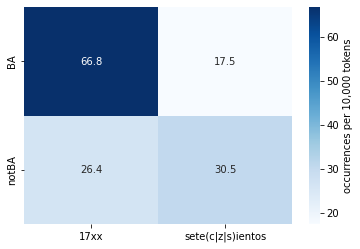

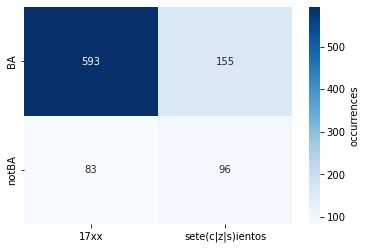

In [152]:
res = np.array([
    [
        clustering_df.loc[clust_mask, 'text'].str.count(r'\b17[0-9]{2}\b').sum(),
        clustering_df.loc[clust_mask, 'text'].str.count(r'\bsete(s|z|c)ientos\b').sum(),
    ],
    [
        clustering_df.loc[~clust_mask, 'text'].str.count(r'\b17[0-9]{2}\b').sum(),
        clustering_df.loc[~clust_mask, 'text'].str.count(r'\bsete(s|z|c)ientos\b').sum(),
    ]
])
xticks_labels = ['17xx','sete(c|z|s)ientos']
ax = sns.heatmap(
    1e4 * (res.T / token_sums).T,
    cmap='Blues', cbar_kws={'label': 'occurrences per 10,000 tokens'},
    annot=True, fmt='.3g'
)
ax.xaxis.set_ticklabels(xticks_labels)
ax.yaxis.set_ticklabels(yticks_labels)
ax.get_figure().savefig(figs_path / 'characteristic_words_freqs' / 'year_rel_freqs.pdf')

fig, ax = plt.subplots()
ax = sns.heatmap(res,  cmap='Blues', annot=True, fmt='d', cbar_kws={'label': 'occurrences'})
ax.xaxis.set_ticklabels(xticks_labels)
ax.yaxis.set_ticklabels(yticks_labels)
ax.get_figure().savefig(figs_path / 'characteristic_words_freqs' / 'year_abs_freqs.pdf')

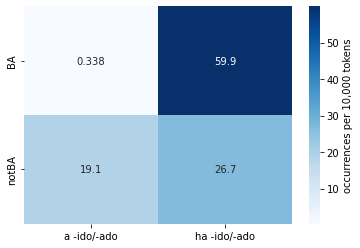

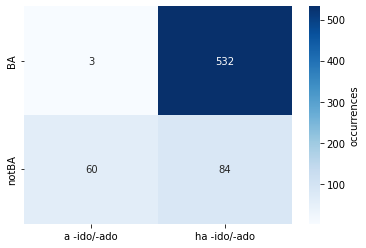

In [153]:
res = np.array([
    [
        clustering_df.loc[clust_mask, 'text'].str.count(r'\ba \w+(i|a)do\b').sum(),
        clustering_df.loc[clust_mask, 'text'].str.count(r'\bha \w+(i|a)do\b').sum(),
    ],
    [
        clustering_df.loc[~clust_mask, 'text'].str.count(r'\ba \w+(i|a)do\b').sum(),
        clustering_df.loc[~clust_mask, 'text'].str.count(r'\bha \w+(i|a)do\b').sum(),
    ]
])

xticks_labels = ['a -ido/-ado','ha -ido/-ado']
ax = sns.heatmap(
    1e4 * (res.T / token_sums).T,
    cmap='Blues', cbar_kws={'label': 'occurrences per 10,000 tokens'},
    annot=True, fmt='.3g'
)
ax.xaxis.set_ticklabels(xticks_labels)
ax.yaxis.set_ticklabels(yticks_labels)
ax.get_figure().savefig(figs_path / 'characteristic_words_freqs' / 'aha_rel_freqs.pdf')

fig, ax = plt.subplots()
ax = sns.heatmap(res,  cmap='Blues', annot=True, fmt='d', cbar_kws={'label': 'occurrences'})
ax.xaxis.set_ticklabels(xticks_labels)
ax.yaxis.set_ticklabels(yticks_labels)
ax.get_figure().savefig(figs_path / 'characteristic_words_freqs' / 'aha_abs_freqs.pdf')

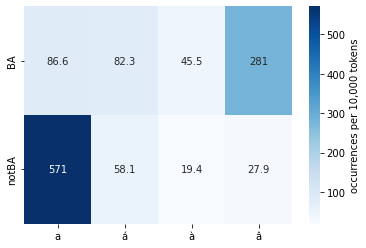

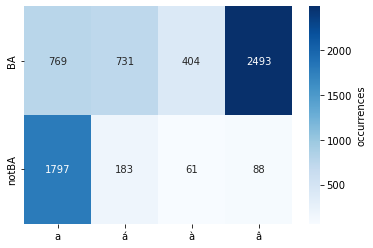

In [154]:
res = np.array([
    [
        clustering_df.loc[clust_mask, 'text'].str.count(r'\ba\b').sum(),
        clustering_df.loc[clust_mask, 'text'].str.count(r'\bá\b').sum(),
        clustering_df.loc[clust_mask, 'text'].str.count(r'\bà\b').sum(),
        clustering_df.loc[clust_mask, 'text'].str.count(r'\bâ\b').sum(),
    ],
    [
        clustering_df.loc[~clust_mask, 'text'].str.count(r'\ba\b').sum(),
        clustering_df.loc[~clust_mask, 'text'].str.count(r'\bá\b').sum(),
        clustering_df.loc[~clust_mask, 'text'].str.count(r'\bà\b').sum(),
        clustering_df.loc[~clust_mask, 'text'].str.count(r'\bâ\b').sum(),
    ]
])

xticks_labels = ['a','á', 'à', 'â']
ax = sns.heatmap(
    1e4 * (res.T / token_sums).T,
    cmap='Blues', cbar_kws={'label': 'occurrences per 10,000 tokens'},
    annot=True, fmt='.3g'
)
ax.xaxis.set_ticklabels(xticks_labels)
ax.yaxis.set_ticklabels(yticks_labels)
ax.get_figure().savefig(figs_path / 'characteristic_words_freqs' / 'a_rel_freqs.pdf')

fig, ax = plt.subplots()
ax = sns.heatmap(res,  cmap='Blues', annot=True, fmt='d', cbar_kws={'label': 'occurrences'})
ax.xaxis.set_ticklabels(xticks_labels)
ax.yaxis.set_ticklabels(yticks_labels)
ax.get_figure().savefig(figs_path / 'characteristic_words_freqs' / 'a_abs_freqs.pdf')

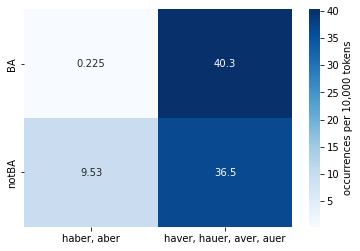

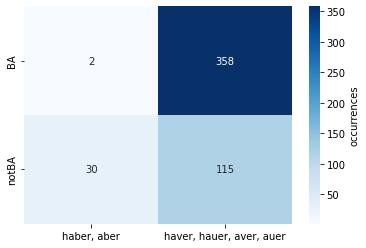

In [218]:
res = np.array([
    [
        clustering_df.loc[clust_mask, 'text'].str.count(r'\bhaber\b').sum()
        + clustering_df.loc[clust_mask, 'text'].str.count(r'\baber\b').sum(),
        clustering_df.loc[clust_mask, 'text'].str.count(r'\bhaver\b').sum()
        + clustering_df.loc[clust_mask, 'text'].str.count(r'\bhauer\b').sum()
        + clustering_df.loc[clust_mask, 'text'].str.count(r'\baver\b').sum()
        + clustering_df.loc[clust_mask, 'text'].str.count(r'\bauer\b').sum(),
    ],
    [
        clustering_df.loc[~clust_mask, 'text'].str.count(r'\bhaber\b').sum()
        + clustering_df.loc[~clust_mask, 'text'].str.count(r'\baber\b').sum(),
        clustering_df.loc[~clust_mask, 'text'].str.count(r'\bhauer\b').sum()
        + clustering_df.loc[~clust_mask, 'text'].str.count(r'\bhaver\b').sum()
        + clustering_df.loc[~clust_mask, 'text'].str.count(r'\baver\b').sum()
        + clustering_df.loc[~clust_mask, 'text'].str.count(r'\bauer\b').sum(),
    ]
])

xticks_labels = ['haber, aber', 'haver, hauer, aver, auer']
ax = sns.heatmap(
    1e4 * (res.T / token_sums).T,
    cmap='Blues', cbar_kws={'label': 'occurrences per 10,000 tokens'},
    annot=True, fmt='.3g'
)
ax.xaxis.set_ticklabels(xticks_labels)
ax.yaxis.set_ticklabels(yticks_labels)
ax.get_figure().savefig(figs_path / 'characteristic_words_freqs' / 'haber_binb_rel_freqs.pdf')

fig, ax = plt.subplots()
ax = sns.heatmap(res,  cmap='Blues', annot=True, fmt='d', cbar_kws={'label': 'occurrences'})
ax.xaxis.set_ticklabels(xticks_labels)
ax.yaxis.set_ticklabels(yticks_labels)
ax.get_figure().savefig(figs_path / 'characteristic_words_freqs' / 'haber_binb_abs_freqs.pdf')

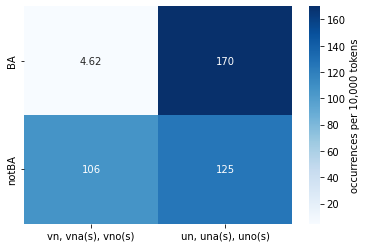

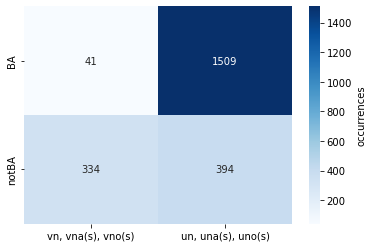

In [220]:
res = np.array([
    [
        clustering_df.loc[clust_mask, 'text'].str.count(r'\bvn((a|o)s*)*\b').sum(),
        clustering_df.loc[clust_mask, 'text'].str.count(r'\bun((a|o)s*)*\b').sum(),
    ],
    [
        clustering_df.loc[~clust_mask, 'text'].str.count(r'\bvn((a|o)s*)*\b').sum(),
        clustering_df.loc[~clust_mask, 'text'].str.count(r'\bun((a|o)s*)*\b').sum(),
    ]
])

xticks_labels = ['vn, vna(s), vno(s)', 'un, una(s), uno(s)']
ax = sns.heatmap(
    1e4 * (res.T / token_sums).T,
    cmap='Blues', cbar_kws={'label': 'occurrences per 10,000 tokens'},
    annot=True, fmt='.3g'
)
ax.xaxis.set_ticklabels(xticks_labels)
ax.yaxis.set_ticklabels(yticks_labels)
ax.get_figure().savefig(figs_path / 'characteristic_words_freqs' / 'uvn_rel_freqs.pdf')

fig, ax = plt.subplots()
ax = sns.heatmap(res,  cmap='Blues', annot=True, fmt='d', cbar_kws={'label': 'occurrences'})
ax.xaxis.set_ticklabels(xticks_labels)
ax.yaxis.set_ticklabels(yticks_labels)
ax.get_figure().savefig(figs_path / 'characteristic_words_freqs' / 'uvn_abs_freqs.pdf')

In [35]:
clustering_df.loc[clust_mask, 'text'].str.extractall(r'\b(a \w+(ado|ido))\b')

0    1
meta_id         match                
AGS02_01        0      a restado  ado
AMMT04          0      a actuado  ado
CORDEREGRA-7003 0       a tenido  ido
                1        a usado  ado
DCEP-0177       0         a dado  ado

### Supervised classification

In [65]:
import sklearn.model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier

KNeighborsClassifier, and any `neighbors` method, can't give the most important words directly, have  to look at resulting group's center

In [83]:
cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
estimators = (
    # ComplementNB(alpha=0.1), MultinomialNB, more for counts
    RidgeClassifier(tol=1e-2, solver="auto"),
    Perceptron(penalty='l2'),
    Perceptron(penalty='l1'),
    PassiveAggressiveClassifier(max_iter=50),
    RandomForestClassifier(),
)

In [84]:
if n_components:
    words_mat = svd.inverse_transform(X)
else:
    words_mat = X.toarray()
bal_center = words_mat[clustering_df['is_BA'], :].mean(axis=0)
notbal_center = words_mat[~clustering_df['is_BA'], :].mean(axis=0)
words_dist = pd.DataFrame({'BAL': bal_center, 'notBAL': notbal_center}, index=tokens)
bal_word_mask = words_dist['BAL'] > words_dist['notBAL']

without svd

In [85]:
for est in estimators:
    res = sklearn.model_selection.cross_validate(
        est,
        X,
        labels,
        cv=cv,
        scoring=[mn.replace('_score', '') for mn in metric_names],
        return_estimator=True,
    )
    print(est)
    display(pd.DataFrame.from_dict(res))
    words_dist['dist'] = 0
    # top_bal_words = set()
    # top_notbal_words = set()
    for e in res['estimator']:
        coefs = getattr(e, 'feature_importances_', getattr(e, 'coef_', None)).flatten()
        # top_features = np.argsort(coefs)[::-1]
        if n_components:
            # top_comp = svd.components_[top_features[0], :]
            words_dist['dist'] += (coefs * svd.components_.T).sum(axis=1)
            # kfold_words = [tokens[i] for i in np.argsort(top_comp)[::-1][:20]]
        else:
            words_dist['dist'] += coefs
            # kfold_words = [tokens[i] for i in top_features[:20]]
    top_bal_words = words_dist.loc[bal_word_mask].nlargest(n=20, columns='dist').index
        # top_bal_words.update(set(kfold_words))
    top_notbal_words = words_dist.loc[~bal_word_mask].nlargest(n=20, columns='dist').index
        # top_notbal_words.update(set(kfold_words))
    print('BAL: ', top_bal_words.to_list())
    print('not BAL: ', top_notbal_words.to_list())

RidgeClassifier(tol=0.01)


,fit_time,score_time,estimator,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_jaccard
0,0.034975,0.010789,RidgeClassifier(tol=0.01),0.950943,0.879576,0.839506,0.918919,0.772727,0.723404
1,0.019598,0.007114,RidgeClassifier(tol=0.01),0.950943,0.861374,0.831169,0.969697,0.727273,0.711111
2,0.017432,0.007108,RidgeClassifier(tol=0.01),0.920455,0.779545,0.704225,0.925926,0.568182,0.543478
3,0.017406,0.007119,RidgeClassifier(tol=0.01),0.939394,0.851415,0.794872,0.885714,0.720930,0.659574
4,0.019412,0.007129,RidgeClassifier(tol=0.01),0.939394,0.832684,0.783784,0.935484,0.674419,0.644444


BAL:  ['á', 'mia', 'paraque', 'buena', 'servir', 'servidora', 'sobrino', 'satisfaccion', 'mutxas', 'suplico', 'rendido', 'd', 'dentro', 'libras', 'huerfanas', 'mismo', 'tuviese', 'querida', 'oraciones', 'salut']
not BAL:  ['quando', 'mucho', 'algo', 'echo', 'memorias', 'dan', 'pase', 'una', 'i', 'modo', 'luego', 'ese', 'escrivi', 'noche', 'seis', 'parece', 'libro', 'autos', 'nadie', 'abra']
Perceptron(penalty='l2')


,fit_time,score_time,estimator,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_jaccard
0,0.083804,0.010230,Perceptron(penalty='l2'),0.909434,0.900195,0.764706,0.672414,0.886364,0.619048
1,0.004781,0.007055,Perceptron(penalty='l2'),0.958491,0.893202,0.864198,0.945946,0.795455,0.760870
2,0.004681,0.006993,Perceptron(penalty='l2'),0.916667,0.822727,0.731707,0.789474,0.681818,0.576923
3,0.004577,0.006949,Perceptron(penalty='l2'),0.943182,0.881774,0.819277,0.850000,0.790698,0.693878
4,0.005219,0.007035,Perceptron(penalty='l2'),0.954545,0.897927,0.853659,0.897436,0.813953,0.744681


BAL:  ['á', 'mia', 'buena', 'satisfaccion', 'mutxas', 'suplico', 'servir', 'ermano', 'libras', 'dentro', 'paraque', 'referido', 'escudos', 'sobrino', 'aguas', 'gustoso', 'salut', 'crea', 'd', 'lamia']
not BAL:  ['quando', 'abra', 'dias', 'noche', 'memorias', 'algo', 'todo', 'obstante', 'cual', 'ay', 'entrego', 'dan', 'libro', 'parece', 'ningun', 'oy', 'una', 'doi', 'escrivi', 'lugar']
Perceptron(penalty='l1')


,fit_time,score_time,estimator,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_jaccard
0,0.014019,0.010315,Perceptron(penalty='l1'),0.905660,0.861528,0.736842,0.686275,0.795455,0.583333
1,0.014117,0.007051,Perceptron(penalty='l1'),0.939623,0.872789,0.809524,0.850000,0.772727,0.680000
2,0.012536,0.007003,Perceptron(penalty='l1'),0.856061,0.786364,0.612245,0.555556,0.681818,0.441176
3,0.011444,0.006986,Perceptron(penalty='l1'),0.916667,0.865937,0.755556,0.723404,0.790698,0.607143
4,0.013914,0.006994,Perceptron(penalty='l1'),0.950758,0.905030,0.847059,0.857143,0.837209,0.734694


BAL:  ['mutxas', 'buena', 'á', 'dentro', 'paraque', 'tuviese', 'salut', 'satisfaccion', 'aguas', 'suplico', 'mia', 'sorteo', 'sobrino', 'servidora', 'servir', 'informe', 'afecta', 'mismo', 'libras', 'd']
not BAL:  ['quando', 'nombre', 'lugar', 'oy', 'i', 'dicha', 'mucho', 'una', 'llama', 'obstante', 'memorias', 'algunos', 'ese', 'tuya', 'cual', 'estar', 'ay', 'dias', 'alos', 'noche']
PassiveAggressiveClassifier(max_iter=50)


,fit_time,score_time,estimator,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_jaccard
0,0.007472,0.007105,PassiveAggressiveClassifier(max_iter=50),0.947170,0.904617,0.840909,0.840909,0.840909,0.725490
1,0.007503,0.007432,PassiveAggressiveClassifier(max_iter=50),0.950943,0.879576,0.839506,0.918919,0.772727,0.723404
2,0.007225,0.006999,PassiveAggressiveClassifier(max_iter=50),0.935606,0.825000,0.773333,0.935484,0.659091,0.630435
3,0.007087,0.006978,PassiveAggressiveClassifier(max_iter=50),0.954545,0.916658,0.860465,0.860465,0.860465,0.755102
4,0.007426,0.007017,PassiveAggressiveClassifier(max_iter=50),0.954545,0.888562,0.850000,0.918919,0.790698,0.739130


BAL:  ['á', 'mia', 'buena', 'paraque', 'mutxas', 'servir', 'sobrino', 'satisfaccion', 'servidora', 'suplico', 'dentro', 'd', 'libras', 'salut', 'mismo', 'rendido', 'ermano', 'huerfanas', 'oraciones', 'infinito']
not BAL:  ['quando', 'algo', 'memorias', 'escrivi', 'dan', 'mucho', 'pase', 'dias', 'echo', 'cual', 'modo', 'ese', 'ay', 'ningun', 'nadie', 'una', 'i', 'trato', 'niño', 'siquiera']
RandomForestClassifier()


,fit_time,score_time,estimator,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_jaccard
0,0.773257,0.042489,"(DecisionTreeClassifier(max_features='auto', r...",0.913208,0.756839,0.666667,0.92,0.522727,0.500000
1,0.691672,0.043089,"(DecisionTreeClassifier(max_features='auto', r...",0.916981,0.750000,0.666667,1.00,0.500000,0.500000
2,0.721146,0.043218,"(DecisionTreeClassifier(max_features='auto', r...",0.909091,0.727273,0.625000,1.00,0.454545,0.454545
3,0.710449,0.042718,"(DecisionTreeClassifier(max_features='auto', r...",0.920455,0.755814,0.676923,1.00,0.511628,0.511628
4,0.701353,0.044288,"(DecisionTreeClassifier(max_features='auto', r...",0.890152,0.662791,0.491228,1.00,0.325581,0.325581


BAL:  ['á', 'mia', 'preceptos', 'sobrino', 'servidora', 'servir', 'buena', 'paraque', 'rendido', 'dezeo', 'perdida', 'noticia', 'tia', 'oraciones', 'ruego', 'mandarme', 'conserve', 'mayor', 'suplico', 'cariño']
not BAL:  ['mio', 'porque', 'pues', 'quando', 'asi', 'ni', 'esto', 'te', 'este', 'quien', 'mui', 'yo', 'mano', 'sin', 'mandar', 'e', 'â', 'un', 'tu', 'digo']


with svd

In [68]:
for est in estimators:
    res = sklearn.model_selection.cross_validate(
        est,
        X,
        labels,
        cv=cv,
        scoring=[mn.replace('_score', '') for mn in metric_names],
        return_estimator=True,
    )
    print(est)
    display(pd.DataFrame.from_dict(res))
    words_dist['dist'] = 0
    # top_bal_words = set()
    # top_notbal_words = set()
    for e in res['estimator']:
        coefs = getattr(e, 'feature_importances_', getattr(e, 'coef_', None)).flatten()
        # top_features = np.argsort(coefs)[::-1]
        if n_components:
            # top_comp = svd.components_[top_features[0], :]
            words_dist['dist'] += (coefs * svd.components_.T).sum(axis=1)
            # kfold_words = [tokens[i] for i in np.argsort(top_comp)[::-1][:20]]
        else:
            words_dist['dist'] += coefs
            # kfold_words = [tokens[i] for i in top_features[:20]]
    top_bal_words = words_dist.loc[bal_word_mask].nlargest(n=20, columns='dist').index
        # top_bal_words.update(set(kfold_words))
    top_notbal_words = words_dist.loc[~bal_word_mask].nlargest(n=20, columns='dist').index
        # top_notbal_words.update(set(kfold_words))
    print('BAL: ', top_bal_words.to_list())
    print('not BAL: ', top_notbal_words.to_list())

RidgeClassifier(tol=0.01)


,fit_time,score_time,estimator,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_jaccard
0,0.008669,0.007368,RidgeClassifier(tol=0.01),0.875472,0.734214,0.582278,0.657143,0.522727,0.410714
1,0.002878,0.007119,RidgeClassifier(tol=0.01),0.932075,0.813657,0.756757,0.933333,0.636364,0.608696
2,0.002893,0.007191,RidgeClassifier(tol=0.01),0.897727,0.765909,0.649351,0.757576,0.568182,0.480769
3,0.002836,0.007176,RidgeClassifier(tol=0.01),0.897727,0.779701,0.658228,0.722222,0.604651,0.490566
4,0.002980,0.007127,RidgeClassifier(tol=0.01),0.928030,0.816532,0.746667,0.875000,0.651163,0.595745


BAL:  ['á', 'mia', 'sobrino', 'tia', 'sor', 'ruego', 'mayor', 'noticia', 'preceptos', 'sus', 'suplico', 'espero', 'vida', 'servir', 'nuestro', 'servidor', 'dezeo', 'perdida', 'necessita', 'presente']
not BAL:  ['q', 'i', 'al', 'todos', 'mis', 'quedo', 'tan', 'uste', 'este', 'dia', 'casa', 'querido', 'tanto', 'ge', 'corazon', 'siempre', 'salud', 'sido', 'muchas', 'ocasion']
Perceptron(penalty='l2')


/home/thomaslouf/.conda/envs/cafeconmiel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,fit_time,score_time,estimator,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_jaccard
0,0.002278,0.007265,Perceptron(penalty='l2'),0.879245,0.709173,0.555556,0.714286,0.454545,0.384615
1,0.002023,0.007174,Perceptron(penalty='l2'),0.833962,0.809441,0.607143,0.500000,0.772727,0.435897
2,0.002555,0.007158,Perceptron(penalty='l2'),0.909091,0.772727,0.675676,0.833333,0.568182,0.510204
3,0.002100,0.011413,Perceptron(penalty='l2'),0.837121,0.500000,0.000000,0.000000,0.000000,0.000000
4,0.002357,0.007297,Perceptron(penalty='l2'),0.920455,0.802641,0.720000,0.843750,0.627907,0.562500


BAL:  ['á', 'mia', 'sobrino', 'tia', 'sor', 'mayor', 'ruego', 'vida', 'noticia', 'suplico', 'servidor', 'rogando', 'servir', 'sus', 'nuestro', 'espero', 'preceptos', 'toda', 'presente', 'seguro']
not BAL:  ['q', 'i', 'â', 'tu', 'te', 'quedo', 'ge', 'todos', 'al', 'as', 'este', 'mis', 'tan', 'ms', 'salud', 'dia', 'tus', 'querido', 'dho', 'siempre']
Perceptron(penalty='l1')


,fit_time,score_time,estimator,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_jaccard
0,0.003214,0.007102,Perceptron(penalty='l1'),0.875472,0.797923,0.645161,0.612245,0.681818,0.476190
1,0.002616,0.006961,Perceptron(penalty='l1'),0.909434,0.818285,0.714286,0.750000,0.681818,0.555556
2,0.004102,0.006997,Perceptron(penalty='l1'),0.708333,0.761364,0.490066,0.345794,0.840909,0.324561
3,0.004940,0.007465,Perceptron(penalty='l1'),0.878788,0.684100,0.515152,0.739130,0.395349,0.346939
4,0.002637,0.006911,Perceptron(penalty='l1'),0.893939,0.777439,0.650000,0.702703,0.604651,0.481481


BAL:  ['á', 'sor', 'mia', 'sobrino', 'vida', 'ruego', 'tia', 'noticia', 'mayor', 'servidor', 'ha', 'suplico', 'sus', 'servir', 'rogando', 'nuestro', 'preceptos', 'toda', 'ÿ', 'presente']
not BAL:  ['â', 'q', 'i', 'uste', 'à', 'al', 'alma', 'este', 'ge', 'quedo', 'tan', 'dia', 'mio', 'ms', 'todos', 'as', 'dela', 'mis', 'tanto', 'sobre']
PassiveAggressiveClassifier(max_iter=50)


,fit_time,score_time,estimator,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_jaccard
0,0.002872,0.007097,PassiveAggressiveClassifier(max_iter=50),0.837736,0.511364,0.044444,1.000000,0.022727,0.022727
1,0.002263,0.006894,PassiveAggressiveClassifier(max_iter=50),0.920755,0.815971,0.734177,0.828571,0.659091,0.580000
2,0.002055,0.007040,PassiveAggressiveClassifier(max_iter=50),0.901515,0.786364,0.675000,0.750000,0.613636,0.509434
3,0.001868,0.006929,PassiveAggressiveClassifier(max_iter=50),0.897727,0.789067,0.666667,0.710526,0.627907,0.500000
4,0.002681,0.006860,PassiveAggressiveClassifier(max_iter=50),0.920455,0.793276,0.712329,0.866667,0.604651,0.553191


BAL:  ['á', 'mia', 'sor', 'sobrino', 'tia', 'mayor', 'ruego', 'vida', 'sus', 'noticia', 'servidor', 'nuestro', 'suplico', 'ha', 'servir', 'espero', 'preceptos', 'rogando', 'presente', 'toda']
not BAL:  ['q', 'i', 'â', 'à', 'al', 'tu', 'este', 'quedo', 'uste', 'te', 'tan', 'todos', 'ge', 'mis', 'dia', 'ms', 'salud', 'tanto', 'mio', 'as']
RandomForestClassifier()


,fit_time,score_time,estimator,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_jaccard
0,0.431669,0.026449,"(DecisionTreeClassifier(max_features='auto', r...",0.901887,0.777355,0.666667,0.764706,0.590909,0.500000
1,0.408319,0.024923,"(DecisionTreeClassifier(max_features='auto', r...",0.943396,0.838647,0.800000,0.967742,0.681818,0.666667
2,0.419405,0.025050,"(DecisionTreeClassifier(max_features='auto', r...",0.916667,0.813636,0.725000,0.805556,0.659091,0.568627
3,0.398014,0.024899,"(DecisionTreeClassifier(max_features='auto', r...",0.924242,0.842366,0.756098,0.794872,0.720930,0.607843
4,0.434644,0.025100,"(DecisionTreeClassifier(max_features='auto', r...",0.935606,0.849153,0.784810,0.861111,0.720930,0.645833


BAL:  ['á', 'sor', 'mia', 'afeto', 'gusto', 'deseos', 'rogando', 'nosotros', 'buena', 'fr', 'cabal', 'cariño', 'tendras', 'grasias', 'estimacion', 'gustosa', 'nra', 'expreciones', 'pretenciones', 'haçer']
not BAL:  ['i', 'te', 'tu', 'uste', 'q', 'usted', 'à', 'alma', 'qe', 'tus', 'as', 'ai', 'ti', 'corazon', 'queria', 'tienes', 'puedes', 'estoi', 'esposo', 'querida']


In [129]:
words_dist

,BAL,notBAL,dist
abajo,0.004813,0.005169,0.000853
aber,0.002145,0.011626,-0.033296
abitacion,0.005423,0.000174,0.011620
abra,0.001088,0.003030,-0.008685
abran,0.000582,0.002962,-0.007615
...,...,...,...
ó,0.025849,0.018942,0.015278
ô,0.038027,0.018293,0.081697
ú,0.002757,0.000958,0.003192
û,0.001795,0.000524,0.004415


In [ ]:
word = 'deella'
doc_df.loc[(doc_df['text'].str.contains(word)) & (~doc_df['raw_text'].str.contains(word))]

,archive,year,locality,region,country,abstract,doc_type,raw_text,text,corpus,is_private,is_BA
meta_id,,,,,,,,,,,,


# Time periods clustering

In [112]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

In [156]:
time_df = auto_df.copy()
# doc_type_mask = doc_df['doc_type'] == 'cartas privadas'
doc_type_mask = ~time_df['is_private']
corpus_mask = time_df['corpus'] == 'corpuscodea'
has_year_mask = time_df['year'].notnull()
doc_mask = doc_type_mask & corpus_mask & has_year_mask

words_count_by_doc = token_counts.count_by_doc(time_df.loc[doc_mask])
global_counts = token_counts.doc_counts_to_global(words_count_by_doc)
global_counts = token_counts.word_mask(global_counts, min_df=5, max_df=0.5, upper_th=0.4)
print(global_counts['word_mask'].sum())
normed_words_count_by_doc = token_counts.filter_doc_counts(
    words_count_by_doc, global_counts['word_mask']
)
normed_words_count_by_doc.head()

8414


count  word_mask
meta_id    word_lower                  
CODEA-0001 adelante        1       True
           affruenta       1       True
           ala             1       True
           alas            3       True
           alcalde         1       True

In [157]:
doc_counts = normed_words_count_by_doc
counts_mat, docs, tokens = doc_counts['count'].astype('Sparse').sparse.to_coo(sort_labels=True)
clustering_df = doc_df.loc[docs].copy()

In [114]:
labels = clustering_df['is_BA'].astype(int)
true_k = 2
n_components = 10

X = counts_mat
transformer = TfidfTransformer(use_idf=True, smooth_idf=False)
X = transformer.fit_transform(X)

print("n_samples: %d, n_features: %d" % X.shape)
print()

if n_components:
    print("Performing dimensionality reduction using LSA")
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    explained_variance = svd.explained_variance_ratio_.sum()
    print(
        "Explained variance of the SVD step: {}%".format(int(explained_variance * 100))
    )

# best scores with 10 components
km = KMeans(n_clusters=true_k,)

print("Clustering sparse data with %s" % km)
km.fit(X)
print()

n_samples: 1997, n_features: 8414

Performing dimensionality reduction using LSA
Explained variance of the SVD step: 11%
Clustering sparse data with KMeans(n_clusters=2)



In [383]:
max_n_clusters = 10
linkage = shc.linkage(X, metric='euclidean', method='ward')

n_clusters = np.asarray(range(2, max_n_clusters + 1))
cut_tree = shc.cut_tree(linkage, n_clusters=n_clusters)

In [384]:
from sklearn.metrics import silhouette_score

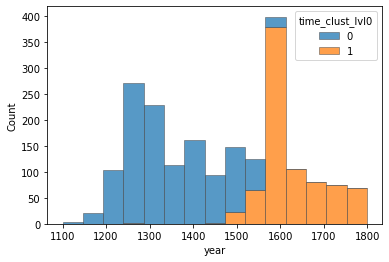

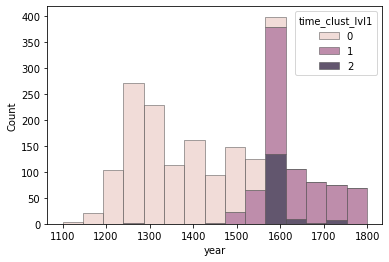

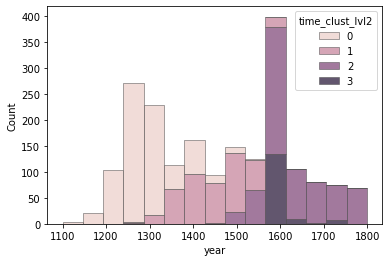

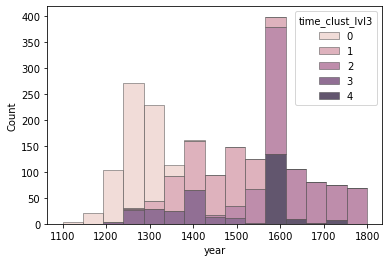

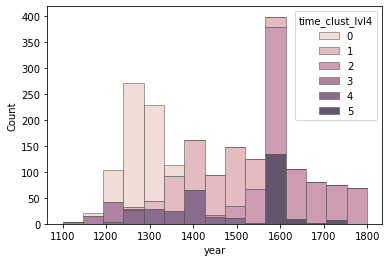

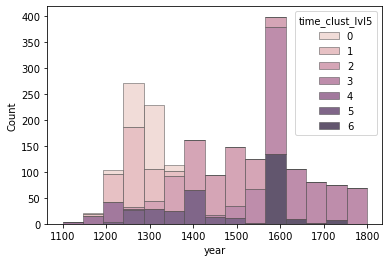

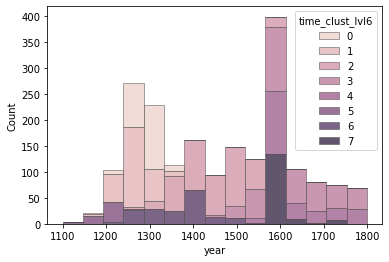

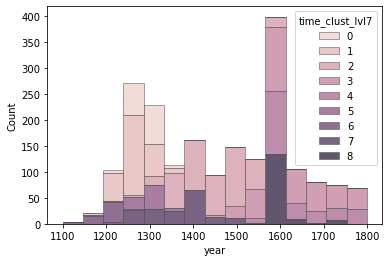

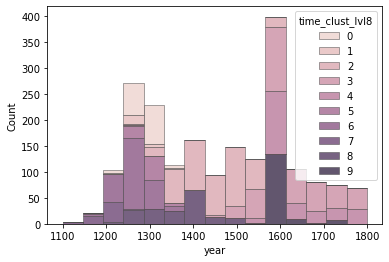

In [385]:
for i, lvl in enumerate(cut_tree.T):
    fig, ax = plt.subplots()
    # print(silhouette_score(X, lvl))
    lvl_col = f'time_clust_lvl{i}'
    clustering_df[lvl_col] = lvl
    ax = sns.histplot(
        clustering_df,
        x="year", hue=lvl_col,
        multiple="stack",
        edgecolor=".3",
        linewidth=.5,
        ax=ax,
    )
    fig.show()

In [115]:
clustering_df['time_clust_lvl0'] = km.labels_

In [116]:
y = 1510
(clustering_df.loc[clustering_df['time_clust_lvl0'] == 0, 'year'] < y).sum(), (clustering_df.loc[clustering_df['time_clust_lvl0'] == 1, 'year'] > y).sum()

(37, 45)

0.23080387873682087
0.23760466434505814
0.28707217040276384
0.3302950074647189
0.3460981082836571


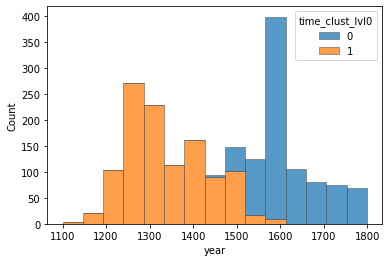

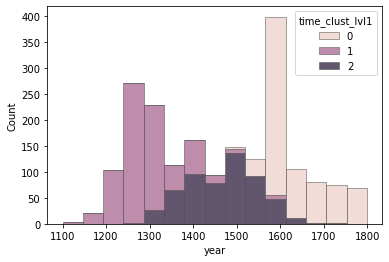

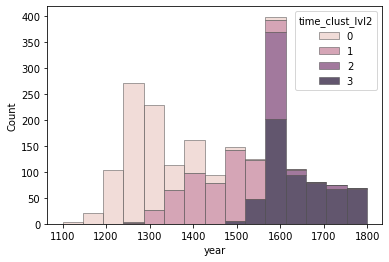

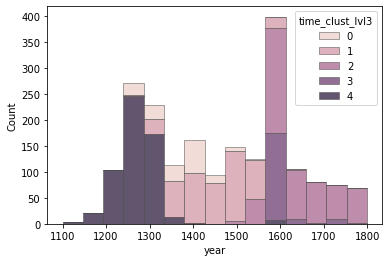

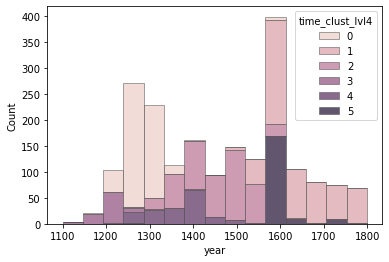

In [394]:
for k in range(2, 7):
    km = KMeans(n_clusters=k,).fit(X)
    fig, ax = plt.subplots()
    lvl_col = f'time_clust_lvl{k-2}'
    clustering_df[lvl_col] = km.labels_
    print(silhouette_score(X, km.labels_))
    ax = sns.histplot(
        clustering_df,
        x="year", hue=lvl_col,
        multiple="stack",
        edgecolor=".3",
        linewidth=.5,
        ax=ax,
    )
    fig.show()

In [340]:
k = 2
km = KMeans(n_clusters=k,).fit(X)
lvl_col = f'time_clust_lvl{k-2}'
cluster_labels = km.labels_
clustering_df[lvl_col] = cluster_labels
if n_components:
    original_space_centroids = svd.inverse_transform(km.cluster_centers_)
else:
    original_space_centroids = km.cluster_centers_

cols = [f'cluster{i}' for i in clustering_df[f'time_clust_lvl{k-2}'].unique()]
words_dist = pd.DataFrame(data=original_space_centroids.T, columns=cols, index=tokens)

for lbl in np.unique(cluster_labels):
    other_clust_cols = [
        col
        for col in words_dist.columns
        if col.startswith('cluster') and col != f'cluster{lbl}'
    ]
    # Dist to closest cluster for every word.
    words_dist[f'dist{lbl}'] = np.min(
        [
            (words_dist[f'cluster{lbl}'] - words_dist[col]).values**2
            for col in other_clust_cols
        ],
        axis=0
    )

In [341]:
words_dist.head()

,cluster1,cluster0,dist0,dist1
aaquellos,0.000023,0.000719,4.847791e-07,4.847791e-07
aauer,0.000145,0.002005,3.460037e-06,3.460037e-06
ab,0.000217,0.001248,1.063622e-06,1.063622e-06
aba,0.002140,0.000217,3.697293e-06,3.697293e-06
abad,0.002863,0.011692,7.795337e-05,7.795337e-05


In [342]:
clust_cols = [f'cluster{i}' for i in np.unique(cluster_labels)]
max_among_clusts = words_dist[clust_cols].max(axis=1)

In [347]:
i = 0
clust_words_mask = words_dist[f'cluster{i}'] == max_among_clusts
print(words_dist.loc[clust_words_mask].nlargest(n=40, columns=f'dist{i}').index.tolist())

['nos', 'uos', 'njn', 'non', 'o', 'vos', 'monesterio', 'dito', 'testis', 'quier', 'dita', 'auos', 'eglesia', 'abbat', 'todo', 'todos', 'perez', 'sant', 'casas', 'confirma', 'mj', 'martin', 'fazer', 'domingo', 'damos', 'alfonso', 'conuento', 'nuestros', 'donna', 'ditos', 'pero', 'pora', 'sobredicho', 'qui', 'prior', 'heredat', 'otorgamos', 'auemos', 'in', 'esto']


In [349]:
clustering_df.loc[clustering_df['text'].str.contains('asy')]

,archive,year,locality,region,country,abstract,doc_type,raw_text,text,corpus,is_private,is_BA,time_clust_lvl2,time_clust_lvl0
meta_id,,,,,,,,,,,,,,
CODEA-0008,Archivo Municipal de Guadalajara,1283.0,Medina Del Campo,Valladolid,España,Carta\n plomada de Juan I que sobrecarta otra ...,textos legislativos,"<td class=""textopaleo""><img class=""img-facsimi...",\n Sepan quantos esta carta vieren Como Nos D...,corpuscodea,False,False,3,1
CODEA-0009,Archivo Municipal de Guadalajara,1387.0,Santorcaz,Madrid,España,Acta\n de cumplimiento por el concejo de Santo...,actas y declaraciones,"<td class=""textopaleo""><img class=""img-facsimi...",\n En sant orcat logar & termjno de alcala de...,corpuscodea,False,False,3,1
CODEA-0014,Archivo Municipal de Guadalajara,1460.0,Guadalajara,Guadalajara,España,Real\n provisión de Enrique IV para que Diego ...,textos legislativos,"<td class=""textopaleo""><img class=""img-facsimi...",\n Don enrrique por la gracia de dios Rey de ...,corpuscodea,False,False,3,1
CODEA-0016,Archivo Municipal de Guadalajara,1464.0,Guadalajara,Guadalajara,España,Traslado\n acta de una real provisión de Enriq...,actas y declaraciones,"<td class=""textopaleo""><img class=""img-facsimi...",\n Enla çibdad de guadalfajara ocho dias del ...,corpuscodea,False,False,3,1
CODEA-0021,Archivo Municipal de Guadalajara,1471.0,Segovia,Segovia,España,Real provisión de Enrique IV que prohíbe labra...,textos legislativos,"<td class=""textopaleo""><img class=""img-facsimi...",\n Donenrrique por la gracia de dios Rey de C...,corpuscodea,False,False,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CODEA-2349,Archivo Municipal de Murcia,1455.0,Ávila,Ávila,España,Provisión\n real por la que Enrique IV ordena ...,textos legislativos,"<td class=""textopaleo""><img class=""img-facsimi...",\n Don enrrique porla graçia de dios Rey de c...,corpuscodea,False,False,3,1
CODEA-2350,Archivo Municipal de Murcia,1455.0,Ávila,Ávila,España,Provisión\n real por la que Enrique IV ordena ...,textos legislativos,"<td class=""textopaleo""><img class=""img-facsimi...",\n Don enrrique por la graçia de dios Rey de ...,corpuscodea,False,False,3,1
CODEA-2390,Archivo Histórico Nacional,1454.0,Ávila,Ávila,España,Carta\n de donación por la que Nuño Garzo del ...,cartas de compraventa y contratos,"<td class=""textopaleo""><img class=""img-facsimi...",\n Sepan quantos esta carta de donaçion viere...,corpuscodea,False,False,3,1


In [247]:
words_dist.loc[clust0_word_mask].nlargest(n=20, columns='dist')

,1,0,dist
nos,0.008563,0.162081,0.023568
uos,0.011205,0.132195,0.014639
njn,-0.018981,0.095043,0.013002
non,0.003772,0.109147,0.011104
o,0.030648,0.123404,0.008604
vos,0.001560,0.077088,0.005705
dito,0.000365,0.075454,0.005638
monesterio,0.009561,0.082717,0.005352
testis,-0.007882,0.064778,0.005280
dita,0.001951,0.058444,0.003191


In [249]:
words_dist.loc[~clust0_word_mask].nlargest(n=20, columns='dist')

,1,0,dist
no,0.192731,0.014117,0.031903
vuestra,0.146229,0.009021,0.018826
magestad,0.122930,-0.000406,0.015212
señor,0.106326,0.004191,0.010432
mi,0.113477,0.018348,0.009050
para,0.148207,0.056073,0.008489
niño,0.089611,-0.001056,0.008220
villa,0.118567,0.032862,0.007345
años,0.084274,0.003574,0.006512
llama,0.080039,0.001774,0.006125


In [404]:
cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
estimators = (
    RidgeClassifier(tol=1e-2, solver="auto"),
    Perceptron(penalty='l2'),
    Perceptron(penalty='l1'),
    PassiveAggressiveClassifier(max_iter=50),
    RandomForestClassifier(),
)

In [159]:
# 1510 selected as year where almost as many docs in wrong cluster for both
clustering_df['is_old'] = clustering_df['year'] < 1510

In [407]:
if n_components:
    words_mat = svd.inverse_transform(X)
else:
    words_mat = X.toarray()
old_center = words_mat[clustering_df['is_old'], :].mean(axis=0)
new_center = words_mat[~clustering_df['is_old'], :].mean(axis=0)
words_dist = pd.DataFrame({'old': old_center, 'new': new_center}, index=tokens)
old_word_mask = words_dist['old'] > words_dist['new']

In [409]:
labels = clustering_df['is_old'].astype(int).values
for est in estimators:
    res = sklearn.model_selection.cross_validate(
        est,
        X,
        labels,
        cv=cv,
        scoring=[mn.replace('_score', '') for mn in metric_names],
        return_estimator=True,
    )
    print(est)
    display(pd.DataFrame.from_dict(res))
    words_dist['dist'] = 0
    for e in res['estimator']:
        coefs = getattr(e, 'feature_importances_', getattr(e, 'coef_', None)).flatten()
        # top_features = np.argsort(coefs)[::-1]
        if n_components:
            # top_comp = svd.components_[top_features[0], :]
            words_dist['dist'] += (coefs * svd.components_.T).sum(axis=1)
            # kfold_words = [tokens[i] for i in np.argsort(top_comp)[::-1][:20]]
        else:
            words_dist['dist'] += coefs
            # kfold_words = [tokens[i] for i in top_features[:20]]
    top_old_words = words_dist.loc[old_word_mask].nlargest(n=20, columns='dist').index
        # top_bal_words.update(set(kfold_words))
    top_new_words = words_dist.loc[~old_word_mask].nlargest(n=20, columns='dist').index
        # top_notbal_words.update(set(kfold_words))
    print('old: ', top_old_words.to_list())
    print('new: ', top_new_words.to_list())

RidgeClassifier(tol=0.01)


,fit_time,score_time,estimator,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_jaccard
0,0.015904,0.008588,RidgeClassifier(tol=0.01),0.945000,0.941349,0.951754,0.931330,0.973094,0.907950
1,0.006410,0.008335,RidgeClassifier(tol=0.01),0.952500,0.948659,0.958425,0.935897,0.982063,0.920168
2,0.007133,0.024216,RidgeClassifier(tol=0.01),0.969925,0.970100,0.972973,0.977376,0.968610,0.947368
3,0.012204,0.008864,RidgeClassifier(tol=0.01),0.964912,0.962170,0.969027,0.952174,0.986486,0.939914
4,0.027981,0.011595,RidgeClassifier(tol=0.01),0.964912,0.962742,0.968889,0.956140,0.981982,0.939655


old:  ['testis', 'confirma', 'njn', 'non', 'nos', 'uos', 'o', 'dito', 'mj', 'vos', 'dita', 'monesterio', 'quier', 'eglesia', 'confirmat', 'in', 'auos', 'obispo', 'todos', 'perez']
new:  ['quales', 'merçed', 'pedro', 'd', 'villas', 'clausula', 'firma', 'ofiçiales', 'santa', 'suarez', 'salamanca', 'anjma', 'vltimo', 'fize', 'derecho', 'ofiçios', 'aquella', 'caer', 'alcaçar', 'caualleros']
Perceptron(penalty='l2')


,fit_time,score_time,estimator,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_jaccard
0,0.003438,0.008302,Perceptron(penalty='l2'),0.957500,0.961301,0.960557,0.995192,0.928251,0.924107
1,0.003470,0.012223,Perceptron(penalty='l2'),0.947500,0.941843,0.954644,0.920833,0.991031,0.913223
2,0.003935,0.006857,Perceptron(penalty='l2'),0.902256,0.889205,0.919588,0.851145,1.000000,0.851145
3,0.002221,0.006589,Perceptron(penalty='l2'),0.954887,0.950870,0.960526,0.935897,0.986486,0.924051
4,0.002127,0.006732,Perceptron(penalty='l2'),0.939850,0.932203,0.948718,0.902439,1.000000,0.902439


old:  ['testis', 'njn', 'confirma', 'non', 'mj', 'o', 'vos', 'nos', 'uos', 'dito', 'quier', 'confirmat', 'monesterio', 'dita', 'in', 'eglesia', 'obispo', 'fazer', 'todos', 'alfonso']
new:  ['merçed', 'dios', 'quales', 'pedro', 'enla', 'villas', 'mente', 'santa', 'delas', 'mjll', 'sean', 'sus', 'maria', 'traslado', 'ofiçiales', 'maravedis', 'padre', 'd', 'mayor', 'mill']
Perceptron(penalty='l1')


,fit_time,score_time,estimator,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_jaccard
0,0.003978,0.006998,Perceptron(penalty='l1'),0.970000,0.970181,0.972973,0.977376,0.968610,0.947368
1,0.003475,0.006729,Perceptron(penalty='l1'),0.947500,0.947088,0.952809,0.954955,0.950673,0.909871
2,0.003464,0.007741,Perceptron(penalty='l1'),0.939850,0.944991,0.943662,0.990148,0.901345,0.893333
3,0.003008,0.006774,Perceptron(penalty='l1'),0.977444,0.978012,0.979592,0.986301,0.972973,0.960000
4,0.002951,0.006820,Perceptron(penalty='l1'),0.959900,0.955947,0.964912,0.940171,0.990991,0.932203


old:  ['confirma', 'testis', 'njn', 'non', 'mj', 'o', 'nos', 'uos', 'vos', 'monesterio', 'confirmat', 'obispo', 'in', 'quier', 'eglesia', 'perez', 'alfonso', 'dito', 'martin', 'fazer']
new:  ['pedro', 'dicho', 'dios', 'merçed', 'mayor', 'quales', 'maria', 'fernando', 'lopez', 'd', 'mjll', 'derecho', 'enla', 'santa', 'andres', 'salamanca', 'maravedis', 'suarez', 'mente', 'traslado']
PassiveAggressiveClassifier(max_iter=50)


,fit_time,score_time,estimator,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_jaccard
0,0.002802,0.006993,PassiveAggressiveClassifier(max_iter=50),0.972500,0.974171,0.974943,0.990741,0.959641,0.951111
1,0.002994,0.006747,PassiveAggressiveClassifier(max_iter=50),0.945000,0.947176,0.949541,0.971831,0.928251,0.903930
2,0.002895,0.006718,PassiveAggressiveClassifier(max_iter=50),0.974937,0.974585,0.977578,0.977578,0.977578,0.956140
3,0.002095,0.006694,PassiveAggressiveClassifier(max_iter=50),0.944862,0.938998,0.952381,0.916667,0.990991,0.909091
4,0.002330,0.006593,PassiveAggressiveClassifier(max_iter=50),0.959900,0.958811,0.964126,0.959821,0.968468,0.930736


old:  ['testis', 'confirma', 'njn', 'non', 'mj', 'monesterio', 'uos', 'confirmat', 'o', 'in', 'nos', 'vos', 'dito', 'quier', 'eglesia', 'obispo', 'alfonso', 'perez', 'dita', 'martin']
new:  ['pedro', 'merçed', 'dios', 'd', 'dicho', 'fernando', 'lopez', 'quales', 'salamanca', 'suarez', 'traslado', 'sello', 'andres', 'santa', 'maria', 'mjll', 'anjma', 'torre', 'clausula', 'firma']
RandomForestClassifier()


,fit_time,score_time,estimator,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_jaccard
0,0.481807,0.031993,"(DecisionTreeClassifier(max_features='auto', r...",0.965000,0.963948,0.968750,0.964444,0.973094,0.939394
1,0.490522,0.026350,"(DecisionTreeClassifier(max_features='auto', r...",0.957500,0.955474,0.962306,0.951754,0.973094,0.927350
2,0.485606,0.026155,"(DecisionTreeClassifier(max_features='auto', r...",0.969925,0.970100,0.972973,0.977376,0.968610,0.947368
3,0.478649,0.026747,"(DecisionTreeClassifier(max_features='auto', r...",0.964912,0.963315,0.968750,0.960177,0.977477,0.939394
4,0.490448,0.026023,"(DecisionTreeClassifier(max_features='auto', r...",0.959900,0.960528,0.963636,0.972477,0.954955,0.929825


old:  ['dito', 'dita', 'vos', 'ditos', 'ditas', 'o', 'present', 'nos', 'mj', 'soldos', 'segunt', 'vuestros', 'quj', 'eglesia', 'todos', 'pieça', 'testis', 'capitol', 'sobre', 'njn']
new:  ['nj', 'enla', 'hauer', 'quales', 'aquella', 'enel', 'porel', 'lugar', 'sera', 'santa', 'publica', 'obligacion', 'alas', 'clausula', 'sean', 'conla', 'fue', 'qujer', 'perpetuo', 'fueron']


In [129]:
doc_counts

count  word_mask
meta_id    word_lower                  
CODEA-0001 adelante        1       True
           affruenta       1       True
           ala             1       True
           alas            3       True
           alcalde         1       True
...                      ...        ...
CODEA-2500 vezina          1       True
           viernes         1       True
           vio             1       True
           virtud          1       True
           voluntad        1       True

[286973 rows x 2 columns]

### Posterior look at word frequencies

In [160]:
yticks_labels = ['> 1510','< 1510']
clust_mask = ~clustering_df['is_old'].rename('is_new')
if 'is_new' not in doc_counts.columns:
    doc_counts = doc_counts.join(clust_mask)
token_sums = np.array([
    doc_counts.loc[doc_counts['is_new'], 'count'].sum(),
    doc_counts.loc[~doc_counts['is_new'], 'count'].sum(),
])
print(token_sums)

[119239 426579]


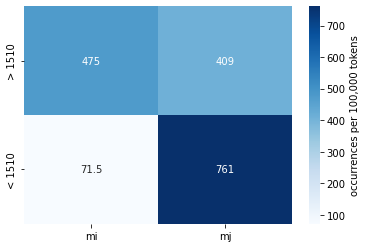

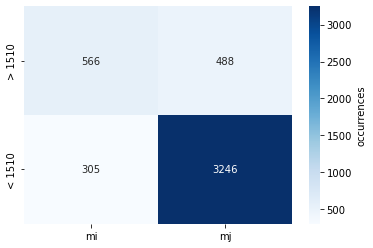

In [162]:
res = np.array([
    [
        clustering_df.loc[clust_mask, 'text'].str.count(r'\bmi\b').sum(),
        clustering_df.loc[clust_mask, 'text'].str.count(r'\bmj\b').sum(),
    ],
    [
        clustering_df.loc[~clust_mask, 'text'].str.count(r'\bmi\b').sum(),
        clustering_df.loc[~clust_mask, 'text'].str.count(r'\bmj\b').sum(),
    ]
])

xticks_labels = ['mi','mj']
ax = sns.heatmap(
    1e5 * (res.T / token_sums).T,
    cmap='Blues', cbar_kws={'label': 'occurrences per 100,000 tokens'},
    annot=True, fmt='.3g'
)
ax.xaxis.set_ticklabels(xticks_labels)
ax.yaxis.set_ticklabels(yticks_labels)
ax.get_figure().savefig(figs_path / 'characteristic_words_freqs' / 'mij_rel_freqs.pdf')

fig, ax = plt.subplots()
ax = sns.heatmap(res,  cmap='Blues', annot=True, fmt='d', cbar_kws={'label': 'occurrences'})
ax.xaxis.set_ticklabels(xticks_labels)
ax.yaxis.set_ticklabels(yticks_labels)
ax.get_figure().savefig(figs_path / 'characteristic_words_freqs' / 'mij_abs_freqs.pdf')

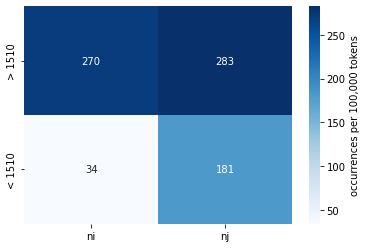

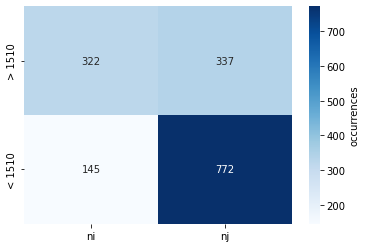

In [165]:
res = np.array([
    [
        clustering_df.loc[clust_mask, 'text'].str.count(r'\bni\b').sum(),
        clustering_df.loc[clust_mask, 'text'].str.count(r'\bnj\b').sum(),
    ],
    [
        clustering_df.loc[~clust_mask, 'text'].str.count(r'\bni\b').sum(),
        clustering_df.loc[~clust_mask, 'text'].str.count(r'\bnj\b').sum(),
    ]
])

xticks_labels = ['ni','nj']
ax = sns.heatmap(
    1e5 * (res.T / token_sums).T,
    cmap='Blues', cbar_kws={'label': 'occurrences per 100,000 tokens'},
    annot=True, fmt='.3g'
)
ax.xaxis.set_ticklabels(xticks_labels)
ax.yaxis.set_ticklabels(yticks_labels)
ax.get_figure().savefig(figs_path / 'characteristic_words_freqs' / 'nij_rel_freqs.pdf')

fig, ax = plt.subplots()
ax = sns.heatmap(res,  cmap='Blues', annot=True, fmt='d', cbar_kws={'label': 'occurrences'})
ax.xaxis.set_ticklabels(xticks_labels)
ax.yaxis.set_ticklabels(yticks_labels)
ax.get_figure().savefig(figs_path / 'characteristic_words_freqs' / 'nij_abs_freqs.pdf')

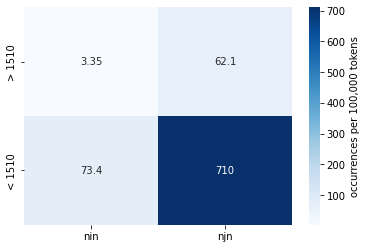

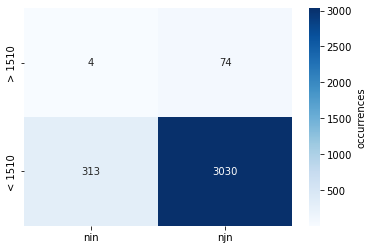

In [166]:
res = np.array([
    [
        clustering_df.loc[clust_mask, 'text'].str.count(r'\bnin\b').sum(),
        clustering_df.loc[clust_mask, 'text'].str.count(r'\bnjn\b').sum(),
    ],
    [
        clustering_df.loc[~clust_mask, 'text'].str.count(r'\bnin\b').sum(),
        clustering_df.loc[~clust_mask, 'text'].str.count(r'\bnjn\b').sum(),
    ]
])

xticks_labels = ['nin','njn']
ax = sns.heatmap(
    1e5 * (res.T / token_sums).T,
    cmap='Blues', cbar_kws={'label': 'occurrences per 100,000 tokens'},
    annot=True, fmt='.3g'
)
ax.xaxis.set_ticklabels(xticks_labels)
ax.yaxis.set_ticklabels(yticks_labels)
ax.get_figure().savefig(figs_path / 'characteristic_words_freqs' / 'nijn_rel_freqs.pdf')

fig, ax = plt.subplots()
ax = sns.heatmap(res,  cmap='Blues', annot=True, fmt='d', cbar_kws={'label': 'occurrences'})
ax.xaxis.set_ticklabels(xticks_labels)
ax.yaxis.set_ticklabels(yticks_labels)
ax.get_figure().savefig(figs_path / 'characteristic_words_freqs' / 'nijn_abs_freqs.pdf')